<a href="https://colab.research.google.com/github/abldvd/CI-Proyects/blob/main/MusicClassifier_SupervisedContrastiveSpectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supervised contrastive code source: https://keras.io/examples/vision/supervised-contrastive-learning/#supervised-contrastive-learning

In [1]:
!pip install pydub
!pip install tensorflow-addons

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
PATH = 'drive/MyDrive/Colab Notebooks/datasets/music_files/test'
MAX_AUDIO_LEN = 60
BIN_SIZE = 2**11
!ls drive/MyDrive/'Colab Notebooks'/datasets/music_files/test

Classical  Rock  Synthwave


In [4]:
import os
import math
import librosa
import numpy as np
import random as rd
from pydub import AudioSegment 
from pydub.utils import make_chunks
from scipy.io import wavfile
from tempfile import mktemp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
def mp32wav(mp3_path, len=None):
  mp3_audio = AudioSegment.from_file(mp3_path, format="mp3")  # read mp3
  if len and len > mp3_audio.duration_seconds:
      raise Exception('Fixed lenght greater than file lenght')
  wname = mktemp('.wav')  # use temporary file
  if len:
    random_midpoint = np.random.randint(int(len*1000/2), int(mp3_audio.duration_seconds*1000 - len*1000/2))
    mp3_audio = mp3_audio[
      random_midpoint - len*1000/2:  
      random_midpoint + len*1000/2] # crop and save to wav
  mp3_audio.export(wname, format="wav")  
  rate, audio = wavfile.read(wname)  # read as wav file
  os.remove(wname) # dont want leaks here
  return audio, rate

In [6]:
def getSpectrogram(mp3_path, bin_size, len): 
  audio, rate = mp32wav(mp3_path, len)  # get wave file  
  audio = np.mean(audio, axis=1)

  spectrum = librosa.stft(audio, n_fft=bin_size, hop_length=int(rate))
  return spectrum[:, :-1].reshape(spectrum[:, :-1].shape+(1,))

In [7]:
def loadSpectrumData(path, seed=1234, file_limit=200):
  # Loads data from a main folder, having the option to split into validation or training 
  first_file_shape = getSpectrogram(f'{path}/{os.listdir(path)[0]}/{os.listdir(f"{path}/{os.listdir(path)[0]}")[0]}', BIN_SIZE, MAX_AUDIO_LEN).shape
  num_files = int(sum([len(os.listdir(f'{path}/{class_folder}')[:file_limit]) for class_folder in os.listdir(path)]))
  num_classes = len(os.listdir(path))
                             # Inits   
  X = np.zeros((num_files,) + first_file_shape, dtype = 'complex_')  # Lets assume every spectrum will have the same shape
  y = np.zeros(num_files, dtype=str)

  rd.seed(seed)
  last_i = 0
  for class_folder in os.listdir(path): # Iterating over the classes
    file_list = os.listdir(f'{path}/{class_folder}')
    rd.shuffle(file_list)
    if file_limit:       # Appliying memory limits and randomizing
      file_list = file_list[:file_limit]
      rd.shuffle(file_list)

    for i, file_name in enumerate(file_list): 
      try:                 
                              # Iterating and loading spectrum
        X[last_i+i,] = getSpectrogram(f'{path}/{class_folder}/{file_name}', BIN_SIZE, MAX_AUDIO_LEN)

      except ValueError as v: # Our assumption was wrong, some files had a rounding error and had one less half a second
        missed_file = getSpectrogram(f'{path}/{class_folder}/{file_name}', BIN_SIZE, MAX_AUDIO_LEN) 
        X[last_i+i,] = np.c_[missed_file, np.ones(np.shape(missed_file)[0], dtype = 'complex_')] # Lets add something so we dont lose the sample
      y[last_i+i] = class_folder
    last_i += i+1
        
  lb = LabelEncoder() # Transforming y to categorical
  y = keras.utils.to_categorical(lb.fit_transform(y), num_classes=num_classes)
  return X,  y

In [8]:
# DATA -------------------------------------------------------------------------
num_classes = len(os.listdir(PATH))
input_shape = getSpectrogram(f'{PATH}/{os.listdir(PATH)[0]}/{os.listdir(f"{PATH}/{os.listdir(PATH)[0]}")[0]}', BIN_SIZE, MAX_AUDIO_LEN).shape
X, y = loadSpectrumData(PATH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
# AUGMENTATION -----------------------------------------------------------------
class ChunkRandomizer(layers.Layer):
  def __init__(self, cuts=6, **kwargs):
    super().__init__(**kwargs)
    self.cuts = cuts

  def call(self, spect):
    spect = tf.split(spect, self.cuts, axis=2)
    rd.shuffle(spect)
    return tf.concat(spect, axis=2)


data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        ChunkRandomizer(),
        layers.GaussianNoise(0.3)
    ]
)
data_augmentation.layers[0].adapt(X_train)

In [22]:
learning_rate = 0.001
batch_size = 44
hidden_units = 128
projection_units = 256
num_epochs = 100
temperature = 0.1

# MODEL ------------------------------------------------------------------------

def create_encoder():
    encoder = keras.Sequential()
     
    encoder.add(layers.Input(input_shape))
    encoder.add(data_augmentation)
    encoder.add(layers.Conv2D(32, kernel_size=(4, 2), activation='relu'))
    encoder.add(layers.Dropout(0.15))
    encoder.add(layers.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(layers.Conv2D(64, kernel_size=(4, 2), activation='relu'))
    encoder.add(layers.Dropout(0.25))
    encoder.add(layers.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(layers.Conv2D(128, kernel_size=(4, 2), activation='relu'))
    encoder.add(layers.Dropout(0.5))
    encoder.add(layers.MaxPooling2D(pool_size=(2, 2)))

    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(hidden_units))

    return encoder


def create_classifier(encoder, trainable=True):
    for layer in encoder.layers[:-1]:
        layer.trainable = trainable

    classifier = keras.Sequential()
    classifier.add(layers.Input(input_shape)) 
    classifier.add(encoder)
    classifier.add(layers.Dense(hidden_units, activation="relu"))
    classifier.add(layers.Dropout(0.20))
    classifier.add(layers.Dense(hidden_units/4, activation="relu"))
    classifier.add(layers.Dropout(0.10))
    classifier.add(layers.Dense(num_classes, activation="softmax"))
  
    
    return classifier


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="encoder-with_projection_head"
    )
    return model

class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):  
        
        
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_multilabel_loss(y_true=labels, y_pred=logits)

In [23]:
# PRETRAINING ------------------------------------------------------------------
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, restore_best_weights=True)


history = encoder_with_projection_head.fit(
    x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, callbacks = [es]
)



Epoch 1/100
10/10 [==============================] - 56s 5s/step - loss: 3.6209
Epoch 2/100
10/10 [==============================] - 57s 6s/step - loss: 3.4203
Epoch 3/100
10/10 [==============================] - 55s 5s/step - loss: 3.3578
Epoch 4/100
10/10 [==============================] - 56s 6s/step - loss: 3.2792
Epoch 5/100
10/10 [==============================] - 56s 6s/step - loss: 3.3860
Epoch 6/100
10/10 [==============================] - 56s 6s/step - loss: 3.2875
Epoch 7/100
10/10 [==============================] - 56s 6s/step - loss: 3.2293
Epoch 8/100
10/10 [==============================] - 55s 5s/step - loss: 3.2485
Epoch 9/100
10/10 [==============================] - 55s 5s/step - loss: 3.2465
Epoch 10/100
10/10 [==============================] - 55s 5s/step - loss: 3.2143
Epoch 11/100
10/10 [==============================] - 60s 6s/step - loss: 3.2012
Epoch 12/100
10/10 [==============================] - 55s 5s/step - loss: 3.1764
Epoch 13/100
10/10 [=================

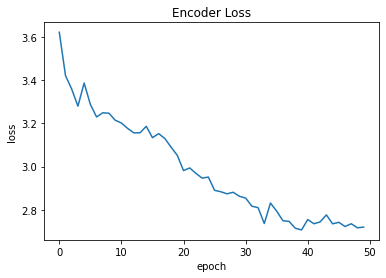

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Encoder Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [25]:
# TRAINING --------------------------------------------------
classifier = create_classifier(encoder, trainable=False)

es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=15, restore_best_weights=True)

classifier.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy()]
    )

history = classifier.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks = [es])

Epoch 1/100
10/10 [==============================] - 32s 3s/step - loss: 6.1017 - categorical_accuracy: 0.6716 - val_loss: 1.9062 - val_categorical_accuracy: 0.7828
Epoch 2/100
10/10 [==============================] - 32s 3s/step - loss: 1.6009 - categorical_accuracy: 0.8582 - val_loss: 1.8434 - val_categorical_accuracy: 0.8232
Epoch 3/100
10/10 [==============================] - 31s 3s/step - loss: 1.6154 - categorical_accuracy: 0.8607 - val_loss: 1.6124 - val_categorical_accuracy: 0.8081
Epoch 4/100
10/10 [==============================] - 31s 3s/step - loss: 2.0393 - categorical_accuracy: 0.8831 - val_loss: 1.7260 - val_categorical_accuracy: 0.8384
Epoch 5/100
10/10 [==============================] - 31s 3s/step - loss: 1.3950 - categorical_accuracy: 0.8657 - val_loss: 0.9807 - val_categorical_accuracy: 0.7879
Epoch 6/100
10/10 [==============================] - 31s 3s/step - loss: 0.9633 - categorical_accuracy: 0.8881 - val_loss: 1.3727 - val_categorical_accuracy: 0.7778
Epoch 7/10

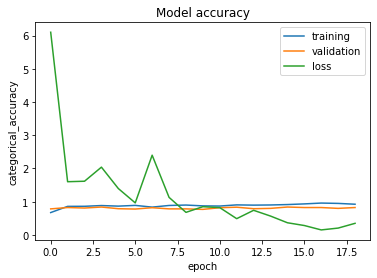

In [26]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()